In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
import os
import time
import argparse
import yaml
import math

# Configuration (can be modified directly in the script)
CONFIG = {
    "dataset": {
        "name": "cifar10",
        "data_dir": "./data",
        "batch_size": 128,
        "num_workers": 2  # Reduced for Colab
    },
    "teacher": {
        "model": "resnet50",
        "pretrained": True,
        "save_path": "/content/teacher_model.pth"  # Path to the teacher model
    },
    "student": {
        "model": "resnet18",
        "pretrained": True,  # Changed to True
        "epochs": 150,       # Increased from 50 to 150
        "learning_rate": 0.01,
        "momentum": 0.9,
        "weight_decay": 0.0005,
        "scheduler": "cosine",  # Changed from step to cosine
        "warmup_epochs": 5,     # Added warmup
        "save_path": "./student_model.pth"  # Simplified path for Colab
    },
    "distillation": {
        "temperature": 6.0,  # Increased from 4.0 to 6.0
        "alpha": 0.7,        # Increased from 0.5 to 0.7 (more weight to soft targets)
        "beta": 0.3,         # Decreased from 0.5 to 0.3 (less weight to hard targets)
        "label_smoothing": 0.1  # Added label smoothing
    }
}

class DistillationLoss:
    """
    Knowledge Distillation Loss

    Combines KL divergence loss between teacher and student soft logits
    and standard cross-entropy loss between student predictions and true labels.
    """

    def __init__(self, alpha=0.5, beta=0.5, temperature=4.0, label_smoothing=0.0):
        self.alpha = alpha
        self.beta = beta
        self.temperature = temperature
        self.ce_loss = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

    def __call__(self, student_logits, teacher_logits, labels):
        """Calculate the distillation loss"""
        # Standard cross-entropy loss between student predictions and true labels
        hard_loss = self.ce_loss(student_logits, labels)

        # KL divergence loss between teacher and student soft logits
        soft_student = F.log_softmax(student_logits / self.temperature, dim=1)
        soft_teacher = F.softmax(teacher_logits / self.temperature, dim=1)
        soft_loss = F.kl_div(soft_student, soft_teacher, reduction='batchmean') * (self.temperature ** 2)

        # Combined loss
        return self.alpha * soft_loss + self.beta * hard_loss

def set_seed(seed=42):
    """Set seed for reproducibility"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_cifar10_dataloaders(batch_size=128, data_dir='./data', num_workers=2):
    """Get CIFAR-10 dataloaders with enhanced augmentation"""
    # Enhanced data augmentation
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Added color jitter
        transforms.RandomRotation(15),  # Added rotation
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.247, 0.243, 0.261)),
        transforms.RandomErasing(p=0.2)  # Added random erasing
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.247, 0.243, 0.261))
    ])

    train_dataset = torchvision.datasets.CIFAR10(
        root=data_dir,
        train=True,
        download=True,
        transform=transform_train
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root=data_dir,
        train=False,
        download=True,
        transform=transform_test
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )

    return train_loader, test_loader

def get_teacher_model(model_name="resnet50", num_classes=10, pretrained=False):
    """Create a teacher model based on the model name"""
    if model_name == "resnet50":
        model = models.resnet50(pretrained=pretrained)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == "resnet18":
        model = models.resnet18(pretrained=pretrained)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    else:
        raise ValueError(f"Unsupported model: {model_name}")

    return model

def get_student_model(model_name="resnet18", num_classes=10, pretrained=False):
    """Create a student model based on the model name"""
    if model_name == "resnet18":
        model = models.resnet18(pretrained=pretrained)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    else:
        raise ValueError(f"Unsupported model: {model_name}")

    return model

def count_parameters(model):
    """Count the number of trainable parameters in the model"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def save_model(model, path):
    """Save model to disk"""
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(model.state_dict(), path)

def load_model(model, path):
    """Load model from disk"""
    model.load_state_dict(torch.load(path))
    return model

class WarmupCosineScheduler:
    """Warmup cosine learning rate scheduler"""
    def __init__(self, optimizer, warmup_epochs, total_epochs, min_lr=1e-6):
        self.optimizer = optimizer
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        self.min_lr = min_lr
        self.base_lrs = [group['lr'] for group in optimizer.param_groups]

    def step(self, epoch):
        if epoch < self.warmup_epochs:
            # Linear warmup
            lr_scale = epoch / self.warmup_epochs
            for i, param_group in enumerate(self.optimizer.param_groups):
                param_group['lr'] = self.base_lrs[i] * lr_scale
        else:
            # Cosine annealing
            progress = (epoch - self.warmup_epochs) / (self.total_epochs - self.warmup_epochs)
            cosine_decay = 0.5 * (1 + math.cos(math.pi * progress))
            for i, param_group in enumerate(self.optimizer.param_groups):
                param_group['lr'] = self.min_lr + (self.base_lrs[i] - self.min_lr) * cosine_decay

def train_student():
    """Train the student model with knowledge distillation"""
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Set seed for reproducibility
    set_seed(42)

    # Get dataloaders
    train_loader, test_loader = get_cifar10_dataloaders(
        batch_size=CONFIG["dataset"]["batch_size"],
        data_dir=CONFIG["dataset"]["data_dir"],
        num_workers=CONFIG["dataset"]["num_workers"]
    )

    # Create teacher model and load weights
    teacher_model = get_teacher_model(
        model_name=CONFIG["teacher"]["model"],
        num_classes=10,
        pretrained=CONFIG["teacher"]["pretrained"]
    )
    teacher_model = load_model(teacher_model, CONFIG["teacher"]["save_path"])
    teacher_model = teacher_model.to(device)
    teacher_model.eval()  # Set to evaluation mode

    # Create student model
    student_model = get_student_model(
        model_name=CONFIG["student"]["model"],
        num_classes=10,
        pretrained=CONFIG["student"]["pretrained"]
    )
    student_model = student_model.to(device)

    # Print model info
    teacher_params = count_parameters(teacher_model)
    student_params = count_parameters(student_model)
    compression_ratio = teacher_params / student_params

    print(f"Teacher model: {CONFIG['teacher']['model']} with {teacher_params:,} parameters")
    print(f"Student model: {CONFIG['student']['model']} with {student_params:,} parameters")
    print(f"Compression ratio: {compression_ratio:.2f}x")

    # Define loss and optimizer
    distillation_loss = DistillationLoss(
        alpha=CONFIG["distillation"]["alpha"],
        beta=CONFIG["distillation"]["beta"],
        temperature=CONFIG["distillation"]["temperature"],
        label_smoothing=CONFIG["distillation"]["label_smoothing"]
    )

    optimizer = optim.SGD(
        student_model.parameters(),
        lr=CONFIG["student"]["learning_rate"],
        momentum=CONFIG["student"]["momentum"],
        weight_decay=CONFIG["student"]["weight_decay"]
    )

    # Define scheduler
    if CONFIG["student"]["scheduler"] == "cosine":
        scheduler = WarmupCosineScheduler(
            optimizer=optimizer,
            warmup_epochs=CONFIG["student"]["warmup_epochs"],
            total_epochs=CONFIG["student"]["epochs"]
        )
    else:
        scheduler = optim.lr_scheduler.StepLR(
            optimizer,
            step_size=CONFIG["student"]["scheduler_step_size"],
            gamma=CONFIG["student"]["scheduler_gamma"]
        )

    # Create model directory if needed
    os.makedirs(os.path.dirname(CONFIG["student"]["save_path"]), exist_ok=True)

    # Training loop
    best_acc = 0.0
    start_time = time.time()

    for epoch in range(1, CONFIG["student"]["epochs"] + 1):
        # Update learning rate for cosine scheduler
        if CONFIG["student"]["scheduler"] == "cosine":
            scheduler.step(epoch)

        # Training phase
        student_model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass through teacher model (no gradient)
            with torch.no_grad():
                teacher_logits = teacher_model(images)

            # Forward pass through student model
            optimizer.zero_grad()
            student_logits = student_model(images)

            # Calculate distillation loss
            loss = distillation_loss(student_logits, teacher_logits, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = student_logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / total
        train_acc = correct / total

        # Evaluation phase
        student_model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)

                # Get teacher predictions
                teacher_logits = teacher_model(images)

                # Get student predictions
                student_logits = student_model(images)

                # Calculate distillation loss
                loss = distillation_loss(student_logits, teacher_logits, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = student_logits.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss /= val_total
        val_acc = val_correct / val_total

        # Print progress
        print(
            f"Epoch [{epoch}/{CONFIG['student']['epochs']}] "
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
            f"LR: {optimizer.param_groups[0]['lr']:.6f}"
        )

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            save_model(student_model, CONFIG["student"]["save_path"])
            print(f"Saved best model with val acc: {best_acc:.4f}")

            # Early stopping if we reach target accuracy
            if best_acc >= 0.9:
                print(f"Reached target accuracy of 90%! Stopping training.")
                break

        # Update learning rate for step scheduler
        if CONFIG["student"]["scheduler"] != "cosine":
            scheduler.step()

    # Log training time and final metrics
    training_time = time.time() - start_time
    print(f"Training complete. Best val acc: {best_acc:.4f}")
    print(f"Total training time: {training_time:.2f} seconds")

if __name__ == "__main__":
    # Train the student model
    train_student()

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 174MB/s]


Teacher model: resnet50 with 23,528,522 parameters
Student model: resnet18 with 11,181,642 parameters
Compression ratio: 2.10x
Epoch [1/150] Train Loss: 1.1998 | Train Acc: 0.4651 | Val Loss: 1.0149 | Val Acc: 0.5858 | LR: 0.002000
Saved best model with val acc: 0.5858
Epoch [2/150] Train Loss: 0.9161 | Train Acc: 0.6207 | Val Loss: 0.7396 | Val Acc: 0.7173 | LR: 0.004000
Saved best model with val acc: 0.7173
Epoch [3/150] Train Loss: 0.8112 | Train Acc: 0.6744 | Val Loss: 0.6274 | Val Acc: 0.7626 | LR: 0.006000
Saved best model with val acc: 0.7626
Epoch [4/150] Train Loss: 0.7648 | Train Acc: 0.7005 | Val Loss: 0.6189 | Val Acc: 0.7659 | LR: 0.008000
Saved best model with val acc: 0.7659
Epoch [5/150] Train Loss: 0.7326 | Train Acc: 0.7157 | Val Loss: 0.5947 | Val Acc: 0.7726 | LR: 0.010000
Saved best model with val acc: 0.7726
Epoch [6/150] Train Loss: 0.6909 | Train Acc: 0.7354 | Val Loss: 0.5513 | Val Acc: 0.7968 | LR: 0.009999
Saved best model with val acc: 0.7968
Epoch [7/150] T

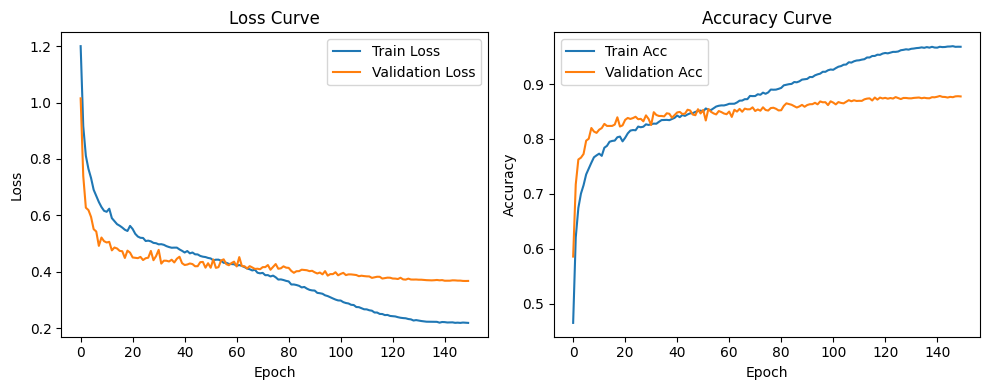

In [ ]:
import re
import matplotlib.pyplot as plt

# Read the training log
with open('/content/student.txt', 'r') as f:
    lines = f.readlines()

train_loss, val_loss = [], []
train_acc, val_acc = [], []

for line in lines:
    match = re.search(
        r"Train Loss: ([0-9.]+) \| Train Acc: ([0-9.]+) \| Val Loss: ([0-9.]+) \| Val Acc: ([0-9.]+)",
        line
    )
    if match:
        train_loss.append(float(match.group(1)))
        train_acc.append(float(match.group(2)))
        val_loss.append(float(match.group(3)))
        val_acc.append(float(match.group(4)))

# Plotting
plt.figure(figsize=(10, 4))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()
